In [2]:
!pip install ucimlrepo

In [1]:

# PCA + Bayes Gaussian (LDA / QDA / GaussianNB) cu selecția lui k prin cross-validation,
# păstrând 20% test curat

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Load dataset 

data = fetch_ucirepo(id=15)
X = data.data.features.copy()
y = data.data.targets.iloc[:, 0].astype(int).to_numpy()

# Mapare etichete: 0=benign(2), 1=malignant(4)
y = (y == 4).astype(int)

# Elimină ID dacă există
if 'Sample_code_number' in X.columns:
    X = X.drop(columns=['Sample_code_number'])

X = X.apply(pd.to_numeric, errors='coerce')


# 80/20 split (test păstrat “curat”)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  CV setup (în interiorul train-ului)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
k_grid = list(range(1, X_train.shape[1] + 1))  # 1..9

def run_grid_search(clf, clf_name):
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("clf", clf)
    ])

    param_grid = {
        "pca__n_components": k_grid
    }

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        return_train_score=True
    )
    gs.fit(X_train, y_train)

    print(f"\n===== {clf_name} (CV on train 80%) =====")
    print("Best k:", gs.best_params_["pca__n_components"])
    print("Best CV accuracy:", gs.best_score_)

    # evaluare FINALĂ pe test 20%
    y_pred = gs.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print("Test accuracy (held-out 20%):", test_acc)

    print("\nConfusion matrix (test):")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred, target_names=["benign(2)", "malignant(4)"]))

    # curba mean CV accuracy vs k
    res = pd.DataFrame(gs.cv_results_)
    curve = (
        res[["param_pca__n_components", "mean_test_score", "std_test_score"]]
        .sort_values("param_pca__n_components")
        .reset_index(drop=True)
    )
    curve.rename(columns={"param_pca__n_components": "k"}, inplace=True)

    return gs, curve


# Rulează pentru LDA, QDA, GaussianNB

gs_lda, curve_lda = run_grid_search(LinearDiscriminantAnalysis(), "LDA")

# QDA poate fi instabil fără regularizare; reg_param ajută
gs_qda, curve_qda = run_grid_search(QuadraticDiscriminantAnalysis(reg_param=1e-3), "QDA")

# Gaussian Naive Bayes (bayes gaussian cu covarianță diagonală)
gs_nb, curve_nb = run_grid_search(GaussianNB(), "GaussianNB")




===== LDA (CV on train 80%) =====
Best k: 6
Best CV accuracy: 0.9660392535392536
Test accuracy (held-out 20%): 0.9357142857142857

Confusion matrix (test):
[[89  3]
 [ 6 42]]

Classification report (test):
              precision    recall  f1-score   support

   benign(2)       0.94      0.97      0.95        92
malignant(4)       0.93      0.88      0.90        48

    accuracy                           0.94       140
   macro avg       0.94      0.92      0.93       140
weighted avg       0.94      0.94      0.94       140


===== QDA (CV on train 80%) =====
Best k: 1
Best CV accuracy: 0.9695945945945945
Test accuracy (held-out 20%): 0.9642857142857143

Confusion matrix (test):
[[89  3]
 [ 2 46]]

Classification report (test):
              precision    recall  f1-score   support

   benign(2)       0.98      0.97      0.97        92
malignant(4)       0.94      0.96      0.95        48

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.

In [32]:
res_lda = pd.DataFrame(gs_lda.cv_results_)

acc_vs_k_lda = (
    res_lda[["param_pca__n_components", "mean_test_score", "std_test_score"]]
    .groupby("param_pca__n_components")
    .mean()
)
print("\nAccuracy LDA în funcție de numărul de componente PCA:")
print(acc_vs_k_lda)


res_nb = pd.DataFrame(gs_nb.cv_results_)

acc_vs_k_nb = (
    res_nb[["param_pca__n_components", "mean_test_score", "std_test_score"]]
    .groupby("param_pca__n_components")
    .mean()
)

print("\nGaussianNB – Accuracy vs k")
print(acc_vs_k_nb)


res_qda = pd.DataFrame(gs_qda.cv_results_)

acc_vs_k_qda = (
    res_qda[["param_pca__n_components", "mean_test_score", "std_test_score"]]
    .groupby("param_pca__n_components")
    .mean()
)

print("\nQDA – Accuracy vs k")
print(acc_vs_k_qda)




Accuracy LDA în funcție de numărul de componente PCA:
                         mean_test_score  std_test_score
param_pca__n_components                                 
1                               0.949887        0.010847
2                               0.960650        0.021567
3                               0.964221        0.018729
4                               0.960650        0.016547
5                               0.958864        0.015546
6                               0.966039        0.016335
7                               0.962484        0.020649
8                               0.964270        0.020339
9                               0.964270        0.020339

GaussianNB – Accuracy vs k
                         mean_test_score  std_test_score
param_pca__n_components                                 
1                               0.969595        0.009087
2                               0.960634        0.013396
3                               0.962420        0.010469
4    

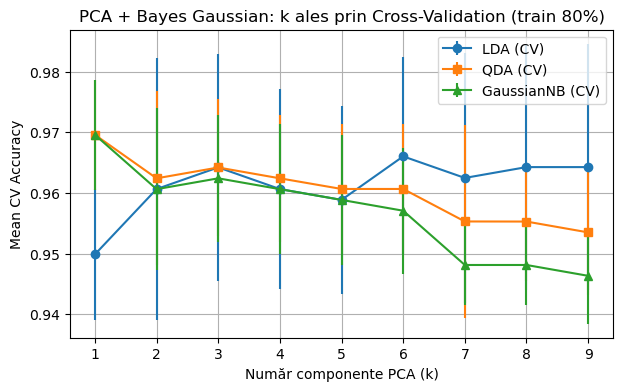

In [2]:

# Plot CV curves

plt.figure(figsize=(7, 4))
plt.errorbar(curve_lda["k"], curve_lda["mean_test_score"], yerr=curve_lda["std_test_score"],
             fmt="o-", label="LDA (CV)")
plt.errorbar(curve_qda["k"], curve_qda["mean_test_score"], yerr=curve_qda["std_test_score"],
             fmt="s-", label="QDA (CV)")
plt.errorbar(curve_nb["k"], curve_nb["mean_test_score"], yerr=curve_nb["std_test_score"],
             fmt="^-", label="GaussianNB (CV)")

plt.xlabel("Număr componente PCA (k)")
plt.ylabel("Mean CV Accuracy")
plt.title("PCA + Bayes Gaussian: k ales prin Cross-Validation (train 80%)")
plt.grid(True)
plt.legend()
plt.show()


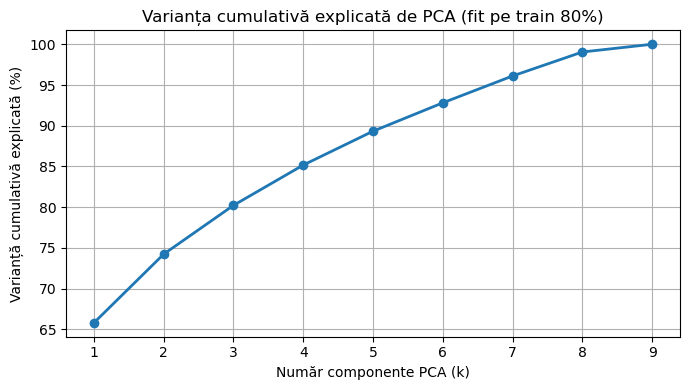

In [4]:

#  Varianță cumulativă explicată de PCA (corect: imputer + scaler pe TRAIN)


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Imputare pe TRAIN (ca în pipeline)
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)

#  Standardizare pe TRAIN (ca în pipeline)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)

#  PCA pe TRAIN
pca_full = PCA()
pca_full.fit(X_train_scaled)

cum_var = np.cumsum(pca_full.explained_variance_ratio_) * 100
ks = np.arange(1, len(cum_var) + 1)

plt.figure(figsize=(7, 4))
plt.plot(ks, cum_var, "o-", linewidth=2)
plt.xlabel("Număr componente PCA (k)")
plt.ylabel("Varianță cumulativă explicată (%)")
plt.title("Varianța cumulativă explicată de PCA (fit pe train 80%)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [5]:

# FUNCȚIE: Plot Confusion Matrix 


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4.5, 4))
    plt.imshow(cm, cmap="Greens")
    plt.title(title)
    plt.colorbar()

    classes = ["benign (2)", "malignant (4)"]
    plt.xticks([0, 1], classes, rotation=45)
    plt.yticks([0, 1], classes)

    # valori în celule
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center",
                     color="black", fontsize=12)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


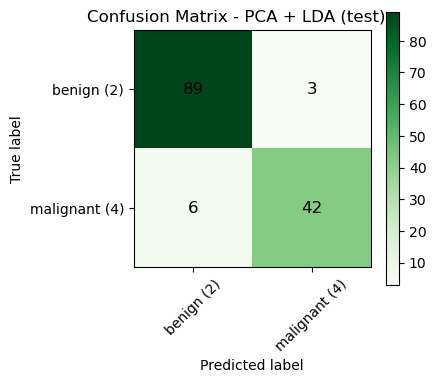

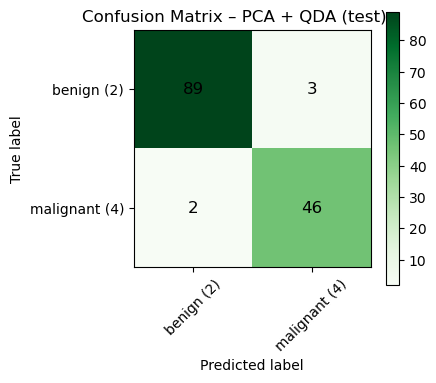

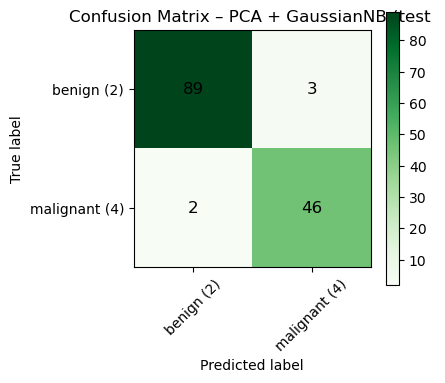

In [26]:
# Predicții LDA pe test (20%)
y_pred_lda = gs_lda.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_lda,
    title="Confusion Matrix - PCA + LDA (test)      ")

# Predicții QDA pe test (20%)
y_pred_qda = gs_qda.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_qda,
    title="Confusion Matrix – PCA + QDA (test)       ")


# Predicții GaussianNB pe test (20%)
y_pred_nb = gs_nb.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_nb,
    title="Confusion Matrix – PCA + GaussianNB (test ")
 



In [10]:
# Parametri ai clasificatorilor :

# GaussianNB

# clf__var_smoothing 
# MODIFICAT DIN : GaussianNB() adica var_smoothing = 1e-9 (implicit)
# MODIFICAT IN : clf__var_smoothing = np.logspace(-12, -6, 7)

# QDA

# clf__reg_param (regularizare covarianță)
# MODIFICAT DIN : QuadraticDiscriminantAnalysis(reg_param=1e-3)
# MODIFICAT IN : clf__reg_param = [0, 1e-4, 1e-3, 1e-2, 1e-1]

# LDA

# clf__solver și clf__shrinkage (shrinkage = regularizare, adesea dă cele mai bune rezultate)
# MODIFICAT DIN : LinearDiscriminantAnalysis() ADICA solver implicit: "svd" si fără regularizare (shrinkage=None)
# MODIFICAT IN :   clf__solver = ["lsqr", "eigen"] si clf__shrinkage = ["auto", 0.1, 0.3, 0.5, 0.7, 0.9]



# EXP2 – PCA + Bayes Gaussian cu PARAMETRI AI CLASIFICATORILOR

cv_exp2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
k_grid_exp2 = list(range(1, X_train.shape[1] + 1))  # 1..9


def run_grid_search_exp2(clf, clf_name, clf_param_grid=None):
    # Pipeline IDENTIC, nume funcție diferit
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("clf", clf)
    ])

    # k + parametri clasificator
    param_grid = {"pca__n_components": k_grid_exp2}
    if clf_param_grid is not None:
        param_grid.update(clf_param_grid)

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv_exp2,
        n_jobs=-1,
        return_train_score=True
    )
    gs.fit(X_train, y_train)

    print(f"\n===== EXP2 – {clf_name} (CV on train 80%) =====")
    print("Best params:", gs.best_params_)
    print("Best CV accuracy:", gs.best_score_)

    # evaluare FINALĂ pe test 20%
    y_pred_exp2 = gs.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_exp2)
    print("Test accuracy (held-out 20%):", test_acc)

    print("\nConfusion matrix (test):")
    print(confusion_matrix(y_test, y_pred_exp2))

    print("\nClassification report (test):")
    print(classification_report(
        y_test, y_pred_exp2,
        target_names=["benign(2)", "malignant(4)"]
    ))

    # ⚠️ EXACT CA LA EXP1 (fără agregare suplimentară)
    res = pd.DataFrame(gs.cv_results_)
    curve = (
        res[["param_pca__n_components", "mean_test_score", "std_test_score"]]
        .sort_values("param_pca__n_components")
        .reset_index(drop=True)
    )
    curve.rename(columns={"param_pca__n_components": "k"}, inplace=True)

    return gs, curve



# EXP2: LDA / QDA / GaussianNB (parametri modificați)


# LDA – solver + shrinkage
lda_grid_exp2 = {
    "clf__solver": ["lsqr", "eigen"],
    "clf__shrinkage": ["auto", 0.1, 0.3, 0.5, 0.7, 0.9]
}
gs_lda_exp2, curve_lda_exp2 = run_grid_search_exp2(
    LinearDiscriminantAnalysis(),
    "LDA",
    lda_grid_exp2
)

# QDA – reg_param
qda_grid_exp2 = {
    "clf__reg_param": [0, 1e-4, 1e-3, 1e-2, 1e-1]
}
gs_qda_exp2, curve_qda_exp2 = run_grid_search_exp2(
    QuadraticDiscriminantAnalysis(),
    "QDA",
    qda_grid_exp2
)

# GaussianNB – var_smoothing
nb_grid_exp2 = {
    "clf__var_smoothing": np.logspace(-12, -6, 7)
}
gs_nb_exp2, curve_nb_exp2 = run_grid_search_exp2(
    GaussianNB(),
    "GaussianNB",
    nb_grid_exp2
)




===== EXP2 – LDA (CV on train 80%) =====
Best params: {'clf__shrinkage': 0.3, 'clf__solver': 'lsqr', 'pca__n_components': 8}
Best CV accuracy: 0.966055341055341
Test accuracy (held-out 20%): 0.9285714285714286

Confusion matrix (test):
[[89  3]
 [ 7 41]]

Classification report (test):
              precision    recall  f1-score   support

   benign(2)       0.93      0.97      0.95        92
malignant(4)       0.93      0.85      0.89        48

    accuracy                           0.93       140
   macro avg       0.93      0.91      0.92       140
weighted avg       0.93      0.93      0.93       140


===== EXP2 – QDA (CV on train 80%) =====
Best params: {'clf__reg_param': 0, 'pca__n_components': 1}
Best CV accuracy: 0.9695945945945945
Test accuracy (held-out 20%): 0.9642857142857143

Confusion matrix (test):
[[89  3]
 [ 2 46]]

Classification report (test):
              precision    recall  f1-score   support

   benign(2)       0.98      0.97      0.97        92
malignant(4)  

In [33]:
res_lda_exp2 = pd.DataFrame(gs_lda_exp2.cv_results_)

acc_vs_k_lda_exp2 = (
    res_lda_exp2[["param_pca__n_components", "mean_test_score", "std_test_score"]]
    .groupby("param_pca__n_components")
    .mean()
)

print("\nEXP2 – LDA: Accuracy în funcție de numărul de componente PCA")
print(acc_vs_k_lda_exp2)



res_nb_exp2 = pd.DataFrame(gs_nb_exp2.cv_results_)

acc_vs_k_nb_exp2 = (
    res_nb_exp2[["param_pca__n_components", "mean_test_score", "std_test_score"]]
    .groupby("param_pca__n_components")
    .mean()
)

print("\nEXP2 – GaussianNB: Accuracy vs k")
print(acc_vs_k_nb_exp2)



res_qda_exp2 = pd.DataFrame(gs_qda_exp2.cv_results_)

acc_vs_k_qda_exp2 = (
    res_qda_exp2[["param_pca__n_components", "mean_test_score", "std_test_score"]]
    .groupby("param_pca__n_components")
    .mean()
)

print("\nEXP2 – QDA: Accuracy vs k")
print(acc_vs_k_qda_exp2)




EXP2 – LDA: Accuracy în funcție de numărul de componente PCA
                         mean_test_score  std_test_score
param_pca__n_components                                 
1                               0.951673        0.012245
2                               0.954073        0.019143
3                               0.960942        0.017448
4                               0.961540        0.017875
5                               0.961242        0.017649
6                               0.962157        0.019055
7                               0.962165        0.018318
8                               0.963953        0.019129
9                               0.963953        0.019129

EXP2 – GaussianNB: Accuracy vs k
                         mean_test_score  std_test_score
param_pca__n_components                                 
1                               0.969595        0.009087
2                               0.960634        0.013396
3                               0.962420        0

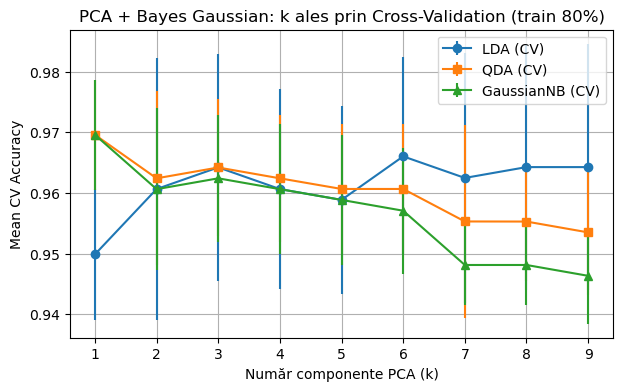

In [11]:

# Plot CV curves (mean +/- std)

plt.figure(figsize=(7, 4))
plt.errorbar(curve_lda["k"], curve_lda["mean_test_score"], yerr=curve_lda["std_test_score"], fmt="o-", label="LDA (CV)")
plt.errorbar(curve_qda["k"], curve_qda["mean_test_score"], yerr=curve_qda["std_test_score"], fmt="s-", label="QDA (CV)")
plt.errorbar(curve_nb["k"],  curve_nb["mean_test_score"],  yerr=curve_nb["std_test_score"],  fmt="^-", label="GaussianNB (CV)")
plt.xlabel("Număr componente PCA (k)")
plt.ylabel("Mean CV Accuracy")
plt.title("PCA + Bayes Gaussian: k ales prin Cross-Validation (train 80%)")
plt.grid(True)
plt.legend()
plt.show()


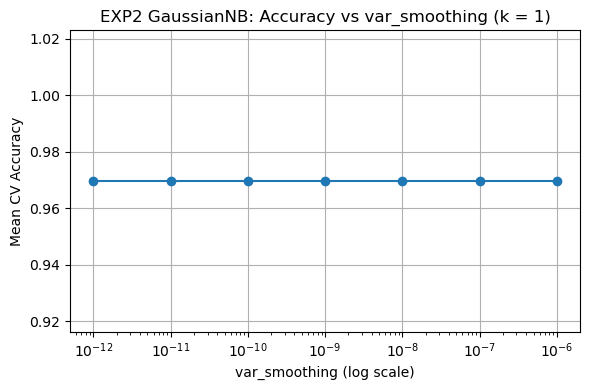

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


# EXP2 GaussianNB: Accuracy vs var_smoothing


res_nb_exp2 = pd.DataFrame(gs_nb_exp2.cv_results_)

best_k_nb_exp2 = gs_nb_exp2.best_params_["pca__n_components"]

df_nb_exp2 = res_nb_exp2[
    res_nb_exp2["param_pca__n_components"] == best_k_nb_exp2
]

plt.figure(figsize=(6, 4))
plt.semilogx(
    df_nb_exp2["param_clf__var_smoothing"],
    df_nb_exp2["mean_test_score"],
    "o-"
)
plt.xlabel("var_smoothing (log scale)")
plt.ylabel("Mean CV Accuracy")
plt.title(f"EXP2 GaussianNB: Accuracy vs var_smoothing (k = {best_k_nb_exp2})")
plt.grid(True)
plt.tight_layout()
plt.show()


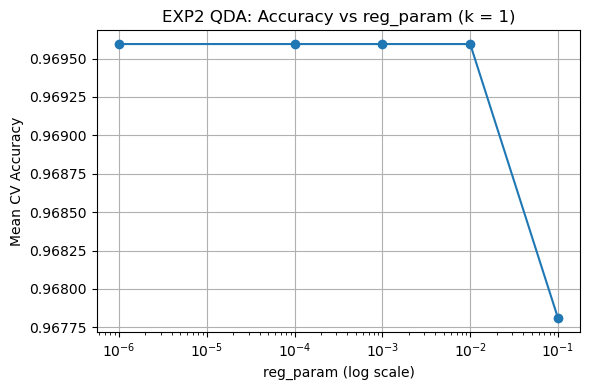

In [14]:

# EXP2 QDA: Accuracy vs reg_param


res_qda_exp2 = pd.DataFrame(gs_qda_exp2.cv_results_)

best_k_qda_exp2 = gs_qda_exp2.best_params_["pca__n_components"]

df_qda_exp2 = res_qda_exp2[
    res_qda_exp2["param_pca__n_components"] == best_k_qda_exp2
]

plt.figure(figsize=(6, 4))
plt.semilogx(
    df_qda_exp2["param_clf__reg_param"].replace(0, 1e-6),
    df_qda_exp2["mean_test_score"],
    "o-"
)
plt.xlabel("reg_param (log scale)")
plt.ylabel("Mean CV Accuracy")
plt.title(f"EXP2 QDA: Accuracy vs reg_param (k = {best_k_qda_exp2})")
plt.grid(True)
plt.tight_layout()
plt.show()


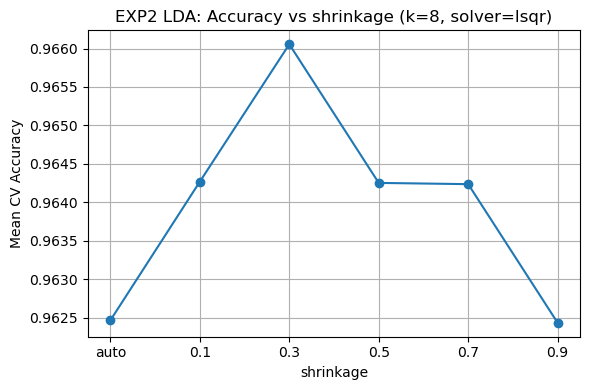

In [15]:

# EXP2 LDA: Accuracy vs shrinkage


res_lda_exp2 = pd.DataFrame(gs_lda_exp2.cv_results_)

best_k_lda_exp2 = gs_lda_exp2.best_params_["pca__n_components"]
best_solver_exp2 = gs_lda_exp2.best_params_["clf__solver"]

df_lda_exp2 = res_lda_exp2[
    (res_lda_exp2["param_pca__n_components"] == best_k_lda_exp2) &
    (res_lda_exp2["param_clf__solver"] == best_solver_exp2)
]

plt.figure(figsize=(6, 4))
plt.plot(
    df_lda_exp2["param_clf__shrinkage"].astype(str),
    df_lda_exp2["mean_test_score"],
    "o-"
)
plt.xlabel("shrinkage")
plt.ylabel("Mean CV Accuracy")
plt.title(
    f"EXP2 LDA: Accuracy vs shrinkage (k={best_k_lda_exp2}, solver={best_solver_exp2})"
)
plt.grid(True)
plt.tight_layout()
plt.show()


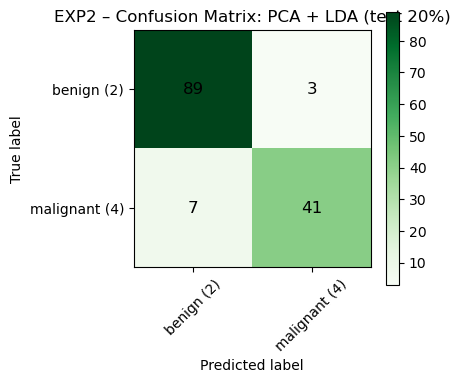

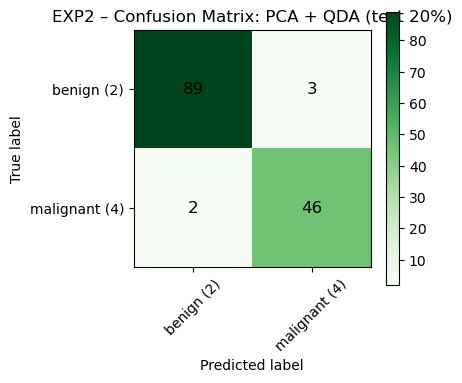

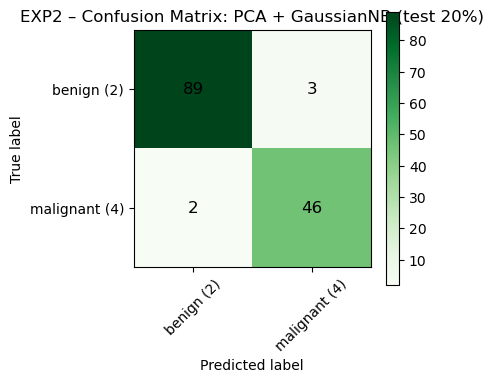

In [18]:

# Predicții LDA pe test (20%)
y_pred_lda_exp2 = gs_lda_exp2.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_lda_exp2,
    title="EXP2 – Confusion Matrix: PCA + LDA (test 20%)"
)


# Predicții QDA pe test (20%)
y_pred_qda_exp2 = gs_qda_exp2.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_qda_exp2,
    title="EXP2 – Confusion Matrix: PCA + QDA (test 20%)"
)


# Predicții GaussianNB pe test (20%)
y_pred_nb_exp2 = gs_nb_exp2.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_nb_exp2,
    title="EXP2 – Confusion Matrix: PCA + GaussianNB (test 20%)"
)



